In [1]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
from dataset.dataset_utils import TUSIMPLE, TUSIMPLE_AUG
from Lanenet.model2 import Lanenet

# Build The datasets

In [2]:
# root = '/Users/smiffy/Documents/GitHub/TUSIMPLE/Data_Tusimple_PyTorch/training'
root = 'TUSIMPLE/txt_for_local'
train_set = TUSIMPLE_AUG(root=root, flag='train')
valid_set = TUSIMPLE_AUG(root=root, flag='valid')
test_set = TUSIMPLE_AUG(root=root, flag='test')

print('train_set length {}'.format(len(train_set)))
print('valid_set length {}'.format(len(valid_set)))
print('test_set length {}'.format(len(test_set)))

train_set length 6164
valid_set length 362
test_set length 726


In [3]:
gt, bgt, igt = train_set[0]
print('image type {}'.format(type(gt)))
print('image size {} \n'.format(gt.size()))

print('gt binary image type {}'.format(type(bgt)))
print('gt binary image size {}'.format(bgt.size()))
print('items in gt binary image {} \n'.format(torch.unique(bgt)))

print('gt instance type {}'.format(type(igt)))
print('gt instance size {}'.format(igt.size()))
print('items in gt instance {} \n'.format(torch.unique(igt)))

image type <class 'torch.Tensor'>
image size torch.Size([3, 256, 512]) 

gt binary image type <class 'torch.Tensor'>
gt binary image size torch.Size([256, 512])
items in gt binary image tensor([0, 1]) 

gt instance type <class 'torch.Tensor'>
gt instance size torch.Size([256, 512])
items in gt instance tensor([  0,  20,  70, 120, 170]) 



# DataLoader

In [4]:
batch_size = 8

data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_valid = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=True, num_workers=0)
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

# Model and optim

In [5]:
learning_rate = 5e-4

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

LaneNet_model = Lanenet(2, 4)
LaneNet_model.to(device)

params = [p for p in LaneNet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0002)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [8]:
num_epochs = 40

In [9]:
from Lanenet.cluster_loss3 import cluster_loss
criterion = cluster_loss()

In [10]:
from torch.autograd import Variable

In [11]:
loss_all = []
for epoch in range(num_epochs):
    LaneNet_model.train()
    ts = time.time()
    for iter, batch in enumerate(data_loader_train):
        input_image = Variable(batch[0]).to(device)
        binary_labels = Variable(batch[1]).to(device)
        instance_labels = Variable(batch[2]).to(device)
        
        binary_final_logits, instance_embedding = LaneNet_model(input_image)
        # loss = LaneNet_model.compute_loss(binary_logits=binary_final_logits, binary_labels=binary_labels,
        #                               instance_logits=instance_embedding, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        binary_segmenatation_loss, instance_segmenatation_loss = criterion(binary_logits=binary_final_logits, binary_labels=binary_labels,
                                       instance_logits=instance_embedding, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        
        # binary_segmenatation_loss = criterion(binary_final_logits, binary_labels)
        loss = 1*binary_segmenatation_loss + 1*instance_segmenatation_loss
        optimizer.zero_grad()
        loss_all.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if iter % 40 == 0:
            print("epoch[{}] iter[{}] loss: [{}, {}] ".format(epoch, iter, binary_segmenatation_loss.item(), instance_segmenatation_loss.item()))
    lr_scheduler.step()
    print("Finish epoch[{}], time elapsed[{}]".format(epoch, time.time() - ts))
    torch.save(LaneNet_model.state_dict(), 
                       f"/TUSIMPLE/Lanenet_output/lanenet_epoch_{epoch}_batch_{8}_AUG.model")

epoch[0] iter[0] loss: [0.8191455006599426, 9.361795425415039] 
epoch[0] iter[40] loss: [0.5152292847633362, 6.026969909667969] 
epoch[0] iter[80] loss: [0.39719387888908386, 3.175370931625366] 
epoch[0] iter[120] loss: [0.34216248989105225, 2.1009573936462402] 
epoch[0] iter[160] loss: [0.30980077385902405, 1.7131037712097168] 
epoch[0] iter[200] loss: [0.3220807611942291, 1.70854914188385] 
epoch[0] iter[240] loss: [0.22905227541923523, 1.1642730236053467] 
epoch[0] iter[280] loss: [0.20727740228176117, 1.098405361175537] 
epoch[0] iter[320] loss: [0.2574497163295746, 1.2304084300994873] 
epoch[0] iter[360] loss: [0.19968612492084503, 0.9792288541793823] 
epoch[0] iter[400] loss: [0.18470756709575653, 0.8610690832138062] 
epoch[0] iter[440] loss: [0.20014259219169617, 1.190737009048462] 
epoch[0] iter[480] loss: [0.2056359350681305, 1.1250542402267456] 
epoch[0] iter[520] loss: [0.19921275973320007, 1.0406765937805176] 
epoch[0] iter[560] loss: [0.16296595335006714, 0.725064992904663

epoch[5] iter[720] loss: [0.10072840750217438, 0.13493019342422485] 
epoch[5] iter[760] loss: [0.13404706120491028, 0.18737109005451202] 
Finish epoch[5], time elapsed[573.5729403495789]
epoch[6] iter[0] loss: [0.10672300308942795, 0.1267934888601303] 
epoch[6] iter[40] loss: [0.12119714915752411, 0.16922158002853394] 
epoch[6] iter[80] loss: [0.1202646866440773, 0.10948043316602707] 
epoch[6] iter[120] loss: [0.12247998267412186, 0.1384057253599167] 
epoch[6] iter[160] loss: [0.109781414270401, 0.1253279149532318] 
epoch[6] iter[200] loss: [0.1245444193482399, 0.14087429642677307] 
epoch[6] iter[240] loss: [0.12204711139202118, 0.12788045406341553] 
epoch[6] iter[280] loss: [0.12381856143474579, 0.11439073830842972] 
epoch[6] iter[320] loss: [0.12689024209976196, 0.13593588769435883] 
epoch[6] iter[360] loss: [0.12371483445167542, 0.27814316749572754] 
epoch[6] iter[400] loss: [0.12218965590000153, 0.12819623947143555] 
epoch[6] iter[440] loss: [0.14200244843959808, 0.1761951744556427

epoch[11] iter[560] loss: [0.1030280590057373, 0.10059009492397308] 
epoch[11] iter[600] loss: [0.12584616243839264, 0.125372514128685] 
epoch[11] iter[640] loss: [0.1106935515999794, 0.11624641716480255] 
epoch[11] iter[680] loss: [0.10660260170698166, 0.1745986044406891] 
epoch[11] iter[720] loss: [0.10348568856716156, 0.09063015878200531] 
epoch[11] iter[760] loss: [0.1048506423830986, 0.08312682807445526] 
Finish epoch[11], time elapsed[566.0226566791534]
epoch[12] iter[0] loss: [0.11142316460609436, 0.09651367366313934] 
epoch[12] iter[40] loss: [0.10900110751390457, 0.09071719646453857] 
epoch[12] iter[80] loss: [0.10442588478326797, 0.0905236229300499] 
epoch[12] iter[120] loss: [0.10256490856409073, 0.12016136944293976] 
epoch[12] iter[160] loss: [0.1296527236700058, 0.14576919376850128] 
epoch[12] iter[200] loss: [0.11970382928848267, 0.1460089236497879] 
epoch[12] iter[240] loss: [0.0893872007727623, 0.08093293011188507] 
epoch[12] iter[280] loss: [0.10912200808525085, 0.0805

epoch[17] iter[320] loss: [0.10383665561676025, 0.08533774316310883] 
epoch[17] iter[360] loss: [0.08769770711660385, 0.08349085599184036] 
epoch[17] iter[400] loss: [0.09543406963348389, 0.0819442868232727] 
epoch[17] iter[440] loss: [0.09007903188467026, 0.09977488964796066] 
epoch[17] iter[480] loss: [0.1157650575041771, 0.10148242861032486] 
epoch[17] iter[520] loss: [0.10331682115793228, 0.08541423082351685] 
epoch[17] iter[560] loss: [0.09712280333042145, 0.0896749198436737] 
epoch[17] iter[600] loss: [0.10210300981998444, 0.08445873111486435] 
epoch[17] iter[640] loss: [0.09493560343980789, 0.08734259754419327] 
epoch[17] iter[680] loss: [0.10790259391069412, 0.12114717066287994] 
epoch[17] iter[720] loss: [0.10348819196224213, 0.07659769058227539] 
epoch[17] iter[760] loss: [0.1355619728565216, 0.16952164471149445] 
Finish epoch[17], time elapsed[565.1305546760559]
epoch[18] iter[0] loss: [0.09320273250341415, 0.07198861241340637] 
epoch[18] iter[40] loss: [0.08883789926767349,

epoch[23] iter[80] loss: [0.08199658989906311, 0.07215652614831924] 
epoch[23] iter[120] loss: [0.08869930356740952, 0.06802044808864594] 
epoch[23] iter[160] loss: [0.06934434175491333, 0.06117093563079834] 
epoch[23] iter[200] loss: [0.07950741797685623, 0.06140842288732529] 
epoch[23] iter[240] loss: [0.08917465060949326, 0.08565214276313782] 
epoch[23] iter[280] loss: [0.08249933272600174, 0.09138937294483185] 
epoch[23] iter[320] loss: [0.08285845071077347, 0.06629472970962524] 
epoch[23] iter[360] loss: [0.09136195480823517, 0.07817798107862473] 
epoch[23] iter[400] loss: [0.08992115408182144, 0.06887319684028625] 
epoch[23] iter[440] loss: [0.08815968036651611, 0.10622882843017578] 
epoch[23] iter[480] loss: [0.09348545223474503, 0.06612003594636917] 
epoch[23] iter[520] loss: [0.08970817178487778, 0.0704876109957695] 
epoch[23] iter[560] loss: [0.0857674777507782, 0.07462014257907867] 
epoch[23] iter[600] loss: [0.07903894037008286, 0.08495820313692093] 
epoch[23] iter[640] los

epoch[28] iter[680] loss: [0.08172861486673355, 0.05636866018176079] 
epoch[28] iter[720] loss: [0.07589983940124512, 0.051847703754901886] 
epoch[28] iter[760] loss: [0.10252660512924194, 0.09366823732852936] 
Finish epoch[28], time elapsed[562.1930923461914]
epoch[29] iter[0] loss: [0.08004079759120941, 0.07112443447113037] 
epoch[29] iter[40] loss: [0.08229754865169525, 0.060033537447452545] 
epoch[29] iter[80] loss: [0.06496092677116394, 0.04883505776524544] 
epoch[29] iter[120] loss: [0.07688969373703003, 0.058737825602293015] 
epoch[29] iter[160] loss: [0.07649166136980057, 0.05614001303911209] 
epoch[29] iter[200] loss: [0.08918707817792892, 0.0792703926563263] 
epoch[29] iter[240] loss: [0.08698274195194244, 0.07213940471410751] 
epoch[29] iter[280] loss: [0.08453754335641861, 0.05927702784538269] 
epoch[29] iter[320] loss: [0.0796503946185112, 0.05838026478886604] 
epoch[29] iter[360] loss: [0.08185742795467377, 0.09166701883077621] 
epoch[29] iter[400] loss: [0.07931020110845

epoch[34] iter[440] loss: [0.08593376725912094, 0.08203341066837311] 
epoch[34] iter[480] loss: [0.07624319940805435, 0.07029964029788971] 
epoch[34] iter[520] loss: [0.07870279997587204, 0.0598335862159729] 
epoch[34] iter[560] loss: [0.08336634188890457, 0.064451664686203] 
epoch[34] iter[600] loss: [0.07398582994937897, 0.05706215649843216] 
epoch[34] iter[640] loss: [0.08660975843667984, 0.06680729240179062] 
epoch[34] iter[680] loss: [0.07226915657520294, 0.07883460819721222] 
epoch[34] iter[720] loss: [0.08149158954620361, 0.05658898875117302] 
epoch[34] iter[760] loss: [0.08312855660915375, 0.0703616663813591] 
Finish epoch[34], time elapsed[560.6405203342438]
epoch[35] iter[0] loss: [0.0795765146613121, 0.05994245037436485] 
epoch[35] iter[40] loss: [0.07942330092191696, 0.06219873204827309] 
epoch[35] iter[80] loss: [0.06834916025400162, 0.05724059045314789] 
epoch[35] iter[120] loss: [0.09078642725944519, 0.06166950985789299] 
epoch[35] iter[160] loss: [0.07915206253528595, 0

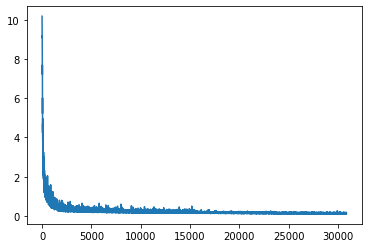

In [12]:
import matplotlib.pylab as plt
plt.plot(loss_all)